<a href="https://colab.research.google.com/github/ssyss-513/MyColab/blob/main/COMP5511/5511_a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

准备工作，先安装deap

In [ ]:
! pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 4.0 MB/s eta 0:00:00


In [1]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt

# DEAP imports
from deap import base, creator, tools, algorithms
import deap.creator as deap_creator

Matplotlib is building the font cache; this may take a moment.


In [ ]:
# ---------------------------
# Helper: safely (re)create DEAP creator classes
# ---------------------------
def reset_deap_creator(fitness_name="FitnessMin", ind_name="Individual"):
    for name in (fitness_name, ind_name):
        if hasattr(deap_creator, name):
            try:
                delattr(deap_creator, name)
            except Exception:
                pass

reset_deap_creator()


In [2]:
# ---------------------------
# Load VRP.csv
# ---------------------------
csv_path = "VRP.csv"
df = pd.read_csv(csv_path, dtype=str)

# Normalize and decide columns
if "NO" in df.columns and any(c.upper().find("CUST") >= 0 for c in df.columns if isinstance(c, str)):
    # try to map standard column names
    cols = {c.upper(): c for c in df.columns}
    col_type = None
    for candidate in ["CUST OR DEPOT", "TYPE", "CUST_OR_DEPOT", "CUST/DEPOT"]:
        if candidate in cols:
            col_type = cols[candidate]
            break
    if col_type is None:
        col_type = df.columns[0]
    col_no = cols.get("NO", df.columns[1] if len(df.columns) > 1 else df.columns[0])
    candidate_coords = [c for c in df.columns if any(x in c.upper() for x in ["X", "LONG", "COORD", "LAT", "Y"])]
    col_x = candidate_coords[0] if len(candidate_coords) >= 1 else df.columns[2]
    col_y = candidate_coords[1] if len(candidate_coords) >= 2 else df.columns[3]
    col_demand = next((c for c in df.columns if "DEMAND" in c.upper()), df.columns[-1])
    df = df.rename(columns={col_type: "TYPE", col_no: "NO", col_x: "XCOORD", col_y: "YCOORD", col_demand: "DEMAND"})
else:
    # fallback: no header
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 5:
        raise ValueError("VRP.csv seems to have fewer than 5 columns.")
    df = df.rename(columns={0: "TYPE", 1: "NO", 2: "XCOORD", 3: "YCOORD", 4: "DEMAND"})

# Convert dtypes
df["TYPE"] = df["TYPE"].astype(str).str.strip()
df["NO"] = df["NO"].astype(int)
df["XCOORD"] = pd.to_numeric(df["XCOORD"])
df["YCOORD"] = pd.to_numeric(df["YCOORD"])
df["DEMAND"] = pd.to_numeric(df["DEMAND"])


In [3]:
df.head(10)

,TYPE,NO,XCOORD,YCOORD,DEMAND,EFFICIENCY
0,DEPOT,0,20.00,20.00,0,0.0
1,DEPOT,1,80.00,20.00,0,0.0
2,DEPOT,2,50.00,50.00,0,0.0
3,DEPOT,3,20.00,80.00,0,0.0
4,DEPOT,4,80.00,80.00,0,0.0
5,CUSTOMER,5,63.94,2.50,9,70.93
6,CUSTOMER,6,10.25,74.07,18,54.77
7,CUSTOMER,7,9.37,23.27,20,79.83
8,CUSTOMER,8,64.99,54.49,8,91.73
9,CUSTOMER,9,86.93,75.88,6,101.04


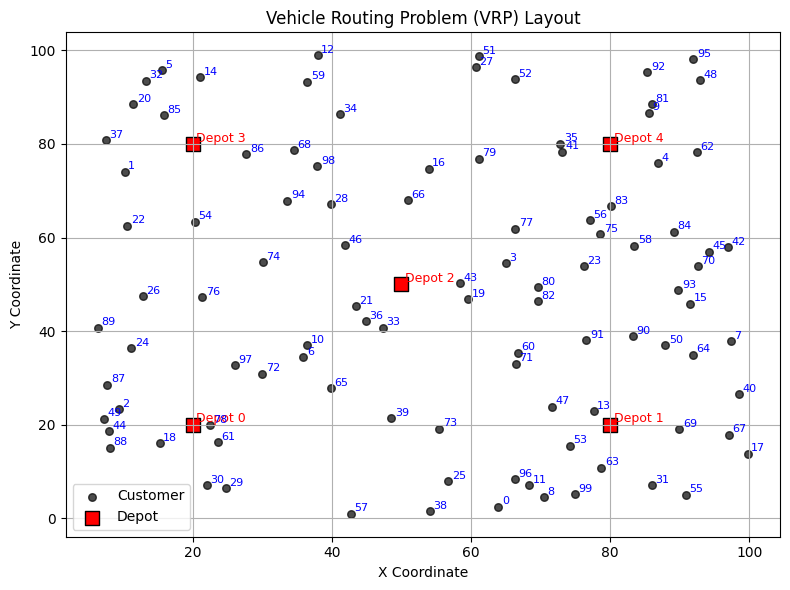

In [4]:
import matplotlib.pyplot as plt

# Separation of depot and customers
depots = df[df["TYPE"].str.upper().str.contains("DEPOT")]
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")]

plt.figure(figsize=(8, 6))

# draw cust
plt.scatter(customers["XCOORD"], customers["YCOORD"],
            c='black', label='Customer', s=30, alpha=0.7)

# draw depot
plt.scatter(depots["XCOORD"], depots["YCOORD"],
            c='red', marker='s', label='Depot', s=100, edgecolors='black')

# Add--
for _, row in depots.iterrows():
    plt.text(row["XCOORD"]+0.5, row["YCOORD"]+0.5, f'Depot {int(row["NO"])}', color='red', fontsize=9)
for _, row in customers.iterrows():
    plt.text(row["XCOORD"]+0.5, row["YCOORD"]+0.5, str(int(row["NO"]-5)), color='blue', fontsize=8)

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Vehicle Routing Problem (VRP) Layout")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df.info()

In [5]:
# ==============================
# Q1: Classical VRP (Robust version)
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random





# -----------------------------
# 2. Split depot and customers
# -----------------------------
depot_row = df[df["TYPE"].str.upper().str.contains("DEPOT")].iloc[0]
depot_no = int(depot_row["NO"])
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy()

coords = {int(row["NO"]):(row["XCOORD"], row["YCOORD"]) for _,row in df.iterrows()}
demands = {int(row["NO"]):float(row["DEMAND"]) for _,row in df.iterrows()}
CAPACITY = 200

idx_to_cust = list(customers["NO"])

# -----------------------------
# 3. Distance matrix
# -----------------------------
def build_distance_matrix(coords):
    nodes = sorted(coords.keys())
    n = len(nodes)
    arr = np.array([coords[k] for k in nodes])
    diff = arr[:,None,:] - arr[None,:,:]
    dist = np.sqrt((diff**2).sum(axis=2))
    node_to_index = {node:i for i,node in enumerate(nodes)}
    return dist, node_to_index

dist_matrix, node_to_index = build_distance_matrix(coords)

# -----------------------------
# 4. Evaluation function
# -----------------------------
def eval_vrp_classical(individual):
    PENALTY = 1e7
    total_dist = 0.0
    load = 0.0
    cur = depot_no
    segments = []
    seg = [depot_no]

    for idx in individual:
        cust = idx_to_cust[idx]
        load += demands[cust]
        if load > CAPACITY:
            total_dist += dist_matrix[node_to_index[cur], node_to_index[depot_no]]
            segments.append(seg + [depot_no])
            seg = [depot_no]
            load = demands[cust]
            cur = depot_no
        total_dist += dist_matrix[node_to_index[cur], node_to_index[cust]]
        seg.append(cust)
        cur = cust

    total_dist += dist_matrix[node_to_index[cur], node_to_index[depot_no]]
    seg.append(depot_no)
    segments.append(seg)

    return (total_dist,), segments

# -----------------------------
# 5. GA setup
# -----------------------------
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(idx_to_cust)), len(idx_to_cust))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate_only(ind):
    val, _ = eval_vrp_classical(ind)
    return val

toolbox.register("evaluate", evaluate_only)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)



In [6]:
import pickle

⚠️ No saved best solution found, initializing population randomly

✅ Best distance: 2013.97


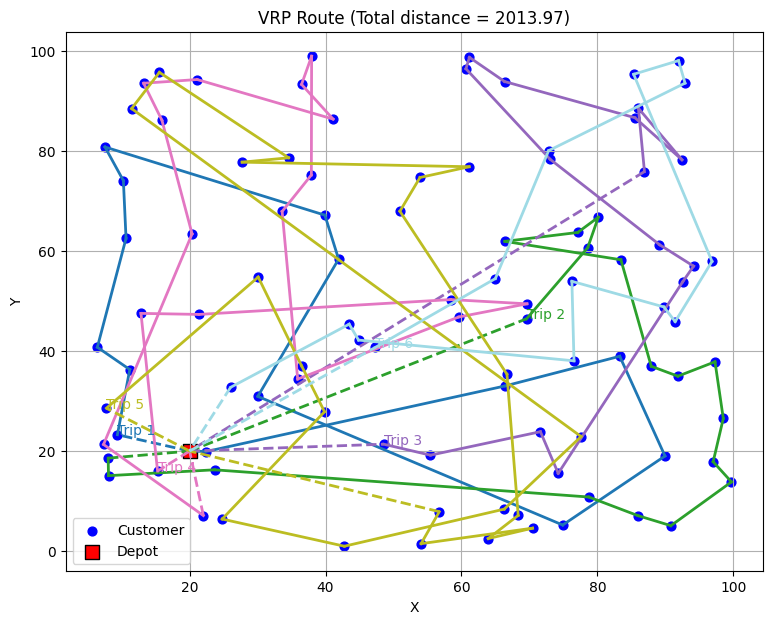

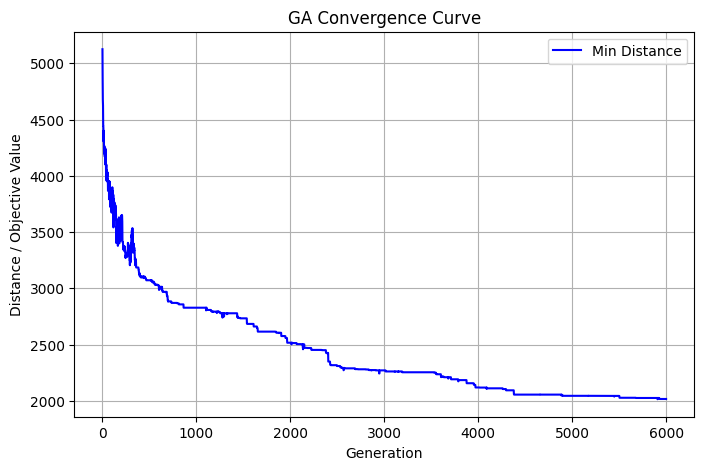

In [7]:
# -----------------------------
# Load saved best solutions (if available)
# -----------------------------
try:
    with open("best_solution_Q1_1.pkl", "rb") as f:
        saved_solutions = pickle.load(f)
    print(f"✅ Loaded {len(saved_solutions)} saved best solutions")
    # Initialize population with saved individuals
    initial_pop = [creator.Individual(sol["individual"]) for sol in saved_solutions]
except FileNotFoundError:
    print("⚠️ No saved best solution found, initializing population randomly")
    initial_pop = []

# -----------------------------
# 6. Run GA
# -----------------------------
n_random = max(0, 100 - len(initial_pop))  # Remaining individuals generated randomly
pop = initial_pop + [toolbox.individual() for _ in range(n_random)]
hof = tools.HallOfFame(1)
hof_save = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.75, mutpb=0.25, ngen=6000,
                    stats=stats, halloffame=hof, verbose=False) # RUN！！！！

best = hof[0]
best_val, best_segments = eval_vrp_classical(best)
print(f"\n✅ Best distance: {best_val[0]:.2f}")

# -----------------------------
# 7. Visualization
# -----------------------------
plt.figure(figsize=(9,7))
plt.scatter(customers["XCOORD"], customers["YCOORD"], c='blue', s=40, label="Customer")
plt.scatter(depot_row["XCOORD"], depot_row["YCOORD"], c='red', marker='s', s=100,
            edgecolors='black', label="Depot")

colors = plt.cm.tab20(np.linspace(0,1,len(best_segments)))

for i, seg in enumerate(best_segments):
    for j in range(len(seg)-1):
        x1, y1 = coords[seg[j]]
        x2, y2 = coords[seg[j+1]]

        if seg[j] == depot_no or seg[j+1] == depot_no:
            # depot to customer
            plt.plot([x1, x2], [y1, y2], color=colors[i], lw=2, linestyle='--')
        else:
            # customer to customer
            plt.plot([x1, x2], [y1, y2], color=colors[i], lw=2, linestyle='-')

    # Mark each trip
    plt.text(coords[seg[1]][0], coords[seg[1]][1], f"Trip {i+1}", color=colors[i])

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Customer → Customer'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Depot → Customer / Customer → Depot')
]
plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

plt.title(f"VRP Route (Total distance = {best_val[0]:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

min_values = logbook.select("min")
avg_values = logbook.select("avg")
max_values = logbook.select("max")

plt.figure(figsize=(8,5))
plt.plot(min_values, label="Min Distance", color='blue')
#plt.plot(avg_values, label="Avg Distance", color='orange')
#plt.plot(max_values, label="Max Distance", color='red')
plt.xlabel("Generation")
plt.ylabel("Distance / Objective Value")
plt.title("GA Convergence Curve")
plt.legend()
plt.grid(True)
plt.show()


**↓执行保存结果**

In [ ]:


best_solutions = []
for i, ind in enumerate(hof_save):
    val, segments = eval_vrp_classical(ind)
    best_solutions.append({"individual": ind, "fitness": val[0], "segments": segments})
    print(f"\nTop {i+1} distance: {val[0]:.2f}")
    for j, s in enumerate(segments):
        print(f"  Trip {j+1}: {' -> '.join(map(str,s))}")

with open("best_solutions_Q1_1.pkl", "wb") as f:
    pickle.dump(best_solutions, f)

print("\n✅ 前10个最优解已保存到 best_solutions_Q1_1.pkl")


✅ 前10个最优解已保存到 best_solutions_Q1_1.pkl


# 多仓库

0 [1, 2, 3, 4]
⚠️ No saved best solution found, initializing population randomly


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



✅ Best distance: 1777.02
Trip 1: 0 -> 36 -> 22 -> 74 -> 18 -> 55 -> 69 -> 72 -> 45 -> 12 -> 47 -> 89 -> 75 -> 95 -> 96 -> 28 -> 63 -> 91 -> 3 -> 42 -> 6 -> 79 -> 77 -> 44 -> 76 -> 65 -> 24 -> 8 -> 82 -> 21 -> 84 -> 46 -> 14 -> 53 -> 100 -> 4 -> 80 -> 61 -> 71 -> 33 -> 51 -> 48 -> 87 -> 60 -> 68 -> 104 -> 101 -> 30 -> 70 -> 11 -> 15 -> 81 -> 26 -> 2 -> 78 -> 16 -> 13 -> 5 -> 62 -> 54 -> 7 -> 92 -> 94 -> 27 -> 39 -> 40 -> 103 -> 10 -> 37 -> 25 -> 90 -> 3 -> 17 -> 64 -> 73 -> 99 -> 59 -> 19 -> 56 -> 32 -> 57 -> 9 -> 88 -> 67 -> 86 -> 97 -> 50 -> 85 -> 2 -> 38 -> 66 -> 34 -> 35 -> 23 -> 93 -> 49 -> 102 -> 43 -> 58 -> 52 -> 20 -> 98 -> 41 -> 31 -> 29 -> 83 -> 0


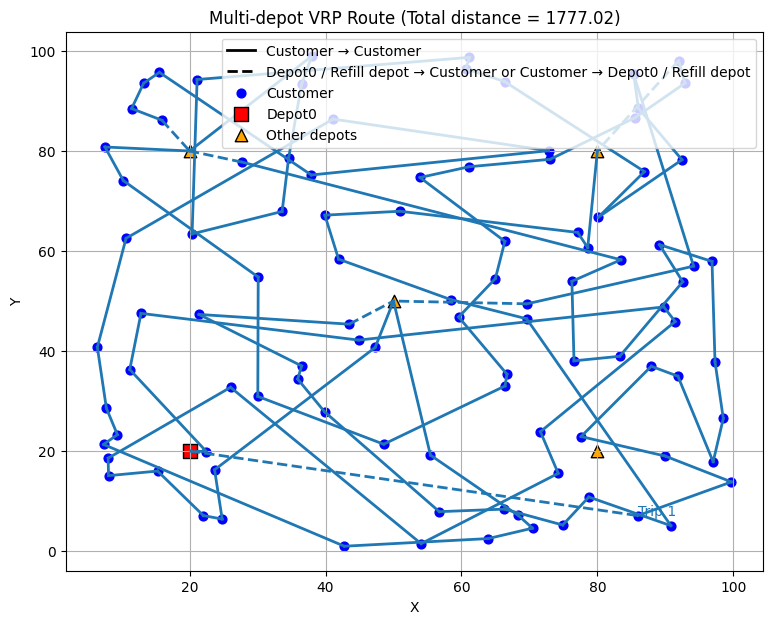

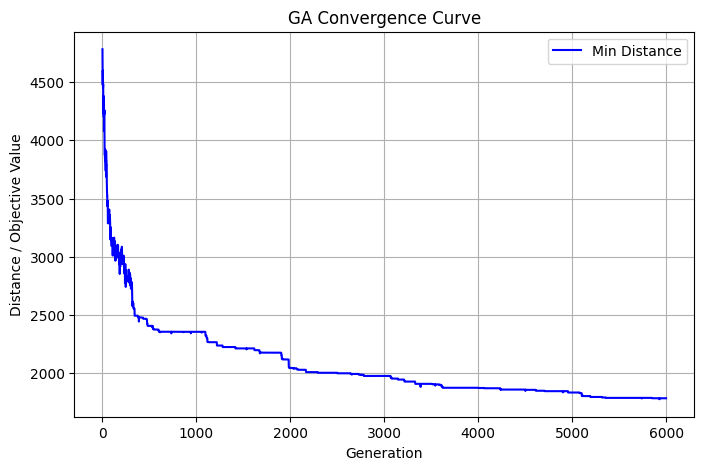

In [ ]:
# Q1: Multi-depot VRP (Depot0 start/end, others as refill)

# All depots
depots = df[df["TYPE"].str.upper().str.contains("DEPOT")]
# Select main depot (e.g., the one with the smallest NO)
main_depot_row = depots.iloc[depots["NO"].idxmin()]
main_depot_no = int(main_depot_row["NO"])

# Other refill depots
other_depots = depots[depots["NO"] != main_depot_no]
other_depot_nos = list(other_depots["NO"])

# Customers
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy()
idx_to_cust = list(customers["NO"])
print(main_depot_no, other_depot_nos)

# Coordinates and demands
coords = {int(row["NO"]):(row["XCOORD"], row["YCOORD"]) for _,row in df.iterrows()}
demands = {int(row["NO"]):float(row["DEMAND"]) for _,row in df.iterrows()}
CAPACITY = 200

# Distance matrix
def build_distance_matrix(coords):
    nodes = sorted(coords.keys())
    arr = np.array([coords[k] for k in nodes])
    diff = arr[:,None,:] - arr[None,:,:]
    dist = np.sqrt((diff**2).sum(axis=2))
    node_to_index = {node:i for i,node in enumerate(nodes)}
    return dist, node_to_index

dist_matrix, node_to_index = build_distance_matrix(coords)

# Evaluation function (multi-depot refill)
def eval_vrp_multi_depot(individual):
    total_dist = 0.0
    load = 0.0
    cur = main_depot_no
    segments = []
    seg = [main_depot_no]

    for idx in individual:
        cust = idx_to_cust[idx]
        load += demands[cust]

        # If overloaded, go to nearest refill depot
        while load > CAPACITY:
            if other_depot_nos:
                nearest_depot = min(other_depot_nos, key=lambda d: dist_matrix[node_to_index[cur], node_to_index[d]])
            else:
                nearest_depot = main_depot_no  # Return to main depot if no refill depots
            total_dist += dist_matrix[node_to_index[cur], node_to_index[nearest_depot]]
            seg.append(nearest_depot)
            cur = nearest_depot
            load = demands[cust]  # Reload and continue

        total_dist += dist_matrix[node_to_index[cur], node_to_index[cust]]
        seg.append(cust)
        cur = cust

    # Return to main depot
    total_dist += dist_matrix[node_to_index[cur], node_to_index[main_depot_no]]
    seg.append(main_depot_no)
    segments.append(seg)

    return (total_dist,), segments

# GA setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(idx_to_cust)), len(idx_to_cust))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", lambda ind: eval_vrp_multi_depot(ind)[0])
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Load saved best solutions (if available)
try:
    with open("best_solutions_multi.pkl", "rb") as f:
        saved_solutions = pickle.load(f)
    print(f"✅ Loaded {len(saved_solutions)} saved best solutions")
    # Initialize population with saved individuals
    initial_pop = [creator.Individual(sol["individual"]) for sol in saved_solutions]
except FileNotFoundError:
    print("⚠️ No saved best solution found, initializing population randomly")
    initial_pop = []

# Run GA
n_random = max(0, 100 - len(initial_pop))  # Generate remaining individuals randomly
pop = initial_pop + [toolbox.individual() for _ in range(n_random)]
hof = tools.HallOfFame(1)
hof_save = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.75, mutpb=0.25, ngen=6000,
                    stats=stats, halloffame=hof, verbose=False)

best = hof[0]
best_val, best_segments = eval_vrp_multi_depot(best)
print(f"\n✅ Best distance: {best_val[0]:.2f}")

# Print each trip route
for i, s in enumerate(best_segments):
    print(f"Trip {i+1}: {' -> '.join(map(str,s))}")

# Visualization
plt.figure(figsize=(9,7))
plt.scatter(customers["XCOORD"], customers["YCOORD"], c='blue', s=40, label="Customer")
plt.scatter(main_depot_row["XCOORD"], main_depot_row["YCOORD"], c='red', marker='s', s=100,
            edgecolors='black', label="Depot0")
plt.scatter(other_depots["XCOORD"], other_depots["YCOORD"], c='orange', marker='^', s=80,
            edgecolors='black', label="Other depots")

colors = plt.cm.tab20(np.linspace(0,1,len(best_segments)))

for i, seg in enumerate(best_segments):
    for j in range(len(seg)-1):
        x1, y1 = coords[seg[j]]
        x2, y2 = coords[seg[j+1]]
        # Dashed line: main or refill depot
        if seg[j] == main_depot_no or seg[j+1] == main_depot_no or seg[j+1] in other_depot_nos:
            plt.plot([x1,x2],[y1,y2], color=colors[i], lw=2, linestyle='--')
        else:
            plt.plot([x1,x2],[y1,y2], color=colors[i], lw=2)

    plt.text(coords[seg[1]][0], coords[seg[1]][1], f"Trip {i+1}", color=colors[i])

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0],[0], color='black', lw=2, linestyle='-', label='Customer → Customer'),
    Line2D([0],[0], color='black', lw=2, linestyle='--', label='Depot0 / Refill depot → Customer or Customer → Depot0 / Refill depot')
]
plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

plt.title(f"Multi-depot VRP Route (Total distance = {best_val[0]:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

min_values = logbook.select("min")
avg_values = logbook.select("avg")
max_values = logbook.select("max")

plt.figure(figsize=(8,5))
plt.plot(min_values, label="Min Distance", color='blue')
#plt.plot(avg_values, label="Avg Distance", color='orange')
#plt.plot(max_values, label="Max Distance", color='red')
plt.xlabel("Generation")
plt.ylabel("Distance / Objective Value")
plt.title("GA Convergence Curve")
plt.legend()
plt.grid(True)
plt.show()


**↓执行保存结果**

In [ ]:
import pickle

best_solutions = []
for i, ind in enumerate(hof_save):
    val, segments = eval_vrp_multi_depot(ind)
    best_solutions.append({"individual": ind, "fitness": val[0], "segments": segments})
    print(f"\nTop {i+1} distance: {val[0]:.2f}")
    for j, s in enumerate(segments):
        print(f"  Trip {j+1}: {' -> '.join(map(str,s))}")

with open("best_solutions_multi.pkl", "wb") as f:
    pickle.dump(best_solutions, f)

print("\n✅ 前10个最优解已保存到 best_solutions_multi.pkl")


✅ 前10个最优解已保存到 best_solutions_multi.pkl


# Q2

gen	nevals	avg    	min    	max    
0  	100   	5406.72	4948.34	5970.33
1  	78    	5250.63	4891.96	5884.45
2  	76    	5173.11	4740.82	5643.21
3  	80    	5106.21	4455.85	5585.98
4  	80    	5035.67	4606.45	5398.99
5  	81    	4998.22	4584.83	5413.75
6  	80    	4936.36	4401.55	5505.39
7  	84    	4886.93	4570.67	5494.4 
8  	81    	4804.7 	4562.38	5325.86
9  	79    	4737.28	4427.73	5172.72
10 	82    	4733.83	4280.18	5314.16
11 	81    	4658.51	4262.47	5038.05
12 	86    	4637.83	4291.96	5205.01
13 	79    	4576.71	4138.59	5181.51
14 	85    	4569.67	4009.96	5123.3 
15 	84    	4529.88	4070.01	5310.48
16 	69    	4435.02	3958.06	5048.01
17 	78    	4380.16	3964.01	5350.95
18 	79    	4330.95	3937.43	5146.35
19 	83    	4325.04	3937.43	4906.42
20 	78    	4284   	3914.07	4750.11
21 	82    	4267.97	3919.33	4929.2 
22 	74    	4246.01	3919.33	5018.76
23 	87    	4247.19	3923.73	5094.77
24 	83    	4219.24	3910.36	4984.73
25 	79    	4215.98	3910.36	4810.23
26 	84    	4189.54	3769.58	4966.55
27 	84    	4171.42	3

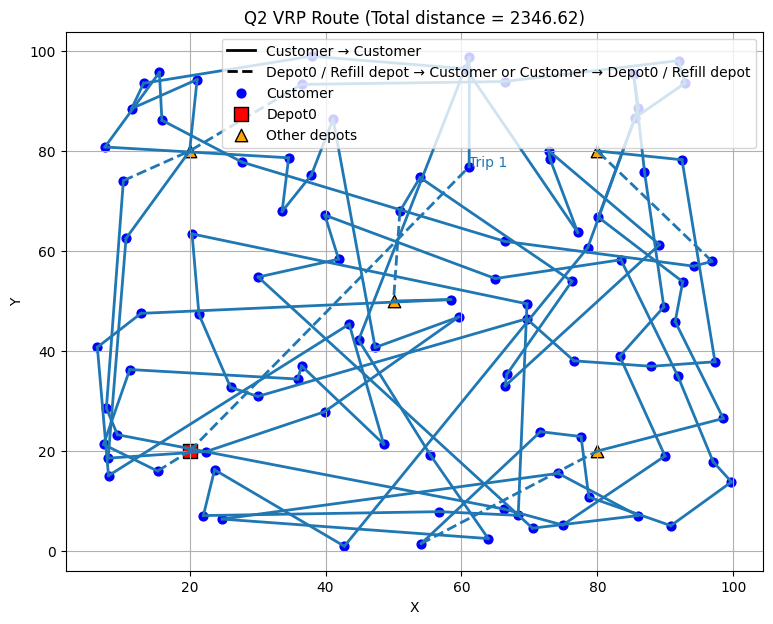

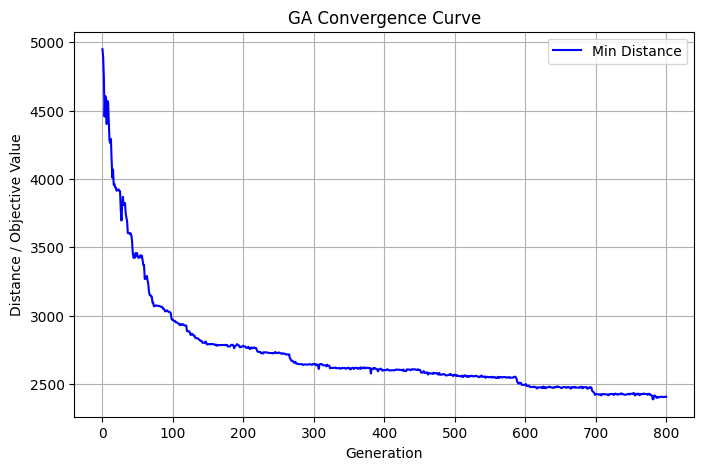

In [ ]:
import numpy as np
import pickle
from deap import algorithms, base, creator, tools

CAPACITY = 200
MC_SAMPLES = 25   # Number of Monte Carlo samples per individual
PENALTY = 1e6     # Penalty

# All depot IDs
depots = list(df[df["TYPE"].str.upper().str.contains("DEPOT")]["NO"])
depot_main = main_depot_no   # Main depot ID
cust_nodes = list(customers["NO"])  # Customer node IDs
demands = dict(zip(df["NO"], df["DEMAND"]))  # Mapping from node to demand

# Generate truncated normal random demands
def sample_demands(mean_demands):
    """Sample from N(mean, 0.2*mean) with resampling for non-positive values."""
    sampled = {}
    for k, mu in mean_demands.items():
        if mu <= 0:
            sampled[k] = 0
        else:
            sd = 0.2 * mu
            x = np.random.normal(mu, sd)
            while x <= 0:
                x = np.random.normal(mu, sd)
            sampled[k] = int(round(x))
    return sampled


# Compute route distance under one random demand sample
def compute_distance_with_sample(individual, sampled_demands):
    total_dist = 0
    load = 0
    cur = depot_main  # Start from the main depot
    feasible = True
    seg = [cur]
    segs = []

    for idx in individual:
        cust = cust_nodes[idx]
        demand = sampled_demands[cust]

        # If a single customer's demand exceeds capacity → infeasible
        if demand > CAPACITY:
            return float('inf'), [], False

        # If current load exceeds capacity, go to the nearest refill depot
        if load + demand > CAPACITY:
            if len(depots) > 1:
                nearest = min([d for d in depots if d != depot_main],
                              key=lambda d: dist_matrix[cur, d])
            else:
                nearest = depot_main
            total_dist += dist_matrix[cur, nearest]
            seg.append(nearest)
            cur = nearest
            load = 0
        # Travel to the customer
        total_dist += dist_matrix[cur, cust]
        cur = cust
        load += demand
        seg.append(cust)

    # Return to main depot
    total_dist += dist_matrix[cur, depot_main]
    seg.append(depot_main)
    segs.append(seg)
    return total_dist, segs, feasible


# Monte Carlo evaluation
def mc_evaluate(individual):
    total_dists = []
    feasible_count = 0

    for _ in range(MC_SAMPLES):
        sampled = sample_demands(demands)
        dist_val, _, feasible = compute_distance_with_sample(individual, sampled)
        if feasible and dist_val < 1e9:
            feasible_count += 1
        total_dists.append(dist_val)

    avg_dist = np.mean(total_dists)
    feas_rate = feasible_count / MC_SAMPLES
    score = avg_dist + PENALTY * (1 - feas_rate)
    return (score,)


# Replace GA evaluation function
toolbox.register("evaluate", mc_evaluate)


# Run Genetic Algorithm
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop = toolbox.population(n=100)
pop, log = algorithms.eaSimple(
    pop, toolbox, cxpb=0.75, mutpb=0.25,
    ngen=800, stats=stats, halloffame=hof, verbose=True
)

best = hof[0]
best_val, best_segments = eval_vrp_multi_depot(best)
print(f"\n✅ Best distance: {best_val[0]:.2f}")

# Visualization
plt.figure(figsize=(9,7))
plt.scatter(customers["XCOORD"], customers["YCOORD"], c='blue', s=40, label="Customer")
plt.scatter(main_depot_row["XCOORD"], main_depot_row["YCOORD"], c='red', marker='s', s=100,
            edgecolors='black', label="Depot0")
plt.scatter(other_depots["XCOORD"], other_depots["YCOORD"], c='orange', marker='^', s=80,
            edgecolors='black', label="Other depots")

colors = plt.cm.tab20(np.linspace(0,1,len(best_segments)))

for i, seg in enumerate(best_segments):
    for j in range(len(seg)-1):
        x1, y1 = coords[seg[j]]
        x2, y2 = coords[seg[j+1]]
        # Dashed lines: Depot0 or refill depot
        if seg[j] == main_depot_no or seg[j+1] == main_depot_no or seg[j+1] in other_depot_nos:
            plt.plot([x1,x2],[y1,y2], color=colors[i], lw=2, linestyle='--')
        else:
            plt.plot([x1,x2],[y1,y2], color=colors[i], lw=2)

    plt.text(coords[seg[1]][0], coords[seg[1]][1], f"Trip {i+1}", color=colors[i])

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0],[0], color='black', lw=2, linestyle='-', label='Customer → Customer'),
    Line2D([0],[0], color='black', lw=2, linestyle='--', label='Depot0 / Refill depot → Customer or Customer → Depot0 / Refill depot')
]
plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

plt.title(f"Q2 VRP Route (Total distance = {best_val[0]:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

# Convergence curve
min_values = log.select("min")
avg_values = log.select("avg")
max_values = log.select("max")

plt.figure(figsize=(8,5))
plt.plot(min_values, label="Min Distance", color='blue')
#plt.plot(avg_values, label="Avg Distance", color='orange')
#plt.plot(max_values, label="Max Distance", color='red')
plt.xlabel("Generation")
plt.ylabel("Distance / Objective Value")
plt.title("GA Convergence Curve")
plt.legend()
plt.grid(True)
plt.show()


save result

In [ ]:
best_solutions = []
for i, ind in enumerate(hof):
    avg_dist = mc_evaluate(ind)[0]
    sampled = sample_demands(demands)
    dist_val, segs, feasible = compute_distance_with_sample(ind, sampled)
    best_solutions.append({
        "rank": i + 1,
        "individual": list(ind),
        "avg_distance": avg_dist,
        "segments": segs,
        "feasible": feasible
    })
    print(f"Top {i+1}: avg_dist={avg_dist:.2f}")

with open("best_solutions_Q2.pkl", "wb") as f:
    pickle.dump(best_solutions, f)
print("✅ 已保存前10个最优解到 best_solutions_Q2.pkl")

Top 1: avg_dist=2390.70
Top 2: avg_dist=2389.16
Top 3: avg_dist=2425.52
Top 4: avg_dist=2415.99
Top 5: avg_dist=2443.25
Top 6: avg_dist=2428.79
Top 7: avg_dist=2434.77
Top 8: avg_dist=2439.41
Top 9: avg_dist=2428.71
Top 10: avg_dist=2424.35
✅ 已保存前10个最优解到 best_solutions_Q2.pkl


# Q3 cluster


增加100个客户

In [ ]:
# Q3: Large-scale VRP by duplicating customers and clustering

import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

# 1) Generate 100 additional customers (by shifting each customer's Y coordinate by +150)
#    Assume there are originally N customers; we take the first 100 customers to shift
#    (or duplicate all and take the first 100)
orig_customers_df = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy()
N_orig = orig_customers_df.shape[0]

# Determine the starting customer ID for new customers (use the max NO from the original data + 1)
max_no = int(df["NO"].max())
new_rows = []
for i in range(100):
    src = orig_customers_df.iloc[i % N_orig]  # Reuse original customers cyclically to create 100 new ones
    max_no += 1
    new_row = src.copy()
    new_row["NO"] = int(max_no)
    new_row["YCOORD"] = float(src["YCOORD"]) + 150.0
    # DEMAND remains the same as the original
    new_rows.append(new_row)

# Add the new customers to df and customers DataFrame
new_customers_df = pd.DataFrame(new_rows)
# Update df, customers, coords, demands, and idx_to_cust
df = pd.concat([df, new_customers_df], ignore_index=True)
# Rebuild the customers DataFrame (excluding DEPOT)
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy().reset_index(drop=True)
# Reconstruct coords and demands
coords = {int(row["NO"]):(row["XCOORD"], row["YCOORD"]) for _,row in df.iterrows()}
demands = {int(row["NO"]):float(row["DEMAND"]) for _,row in df.iterrows()}
idx_to_cust = list(customers["NO"])
print(f"[Q3] Total number of customers = {len(idx_to_cust)} (should be 200). Main depot NO = {depot_no}")


[Q3] Total number of customers = 200 (should be 200). Main depot NO = 0


Kmean

In [ ]:
# 2) Build the distance matrix (covering all nodes)
def build_distance_matrix_from_coords(coords):
    nodes = sorted(coords.keys())
    arr = np.array([coords[k] for k in nodes])
    diff = arr[:, None, :] - arr[None, :, :]
    dist = np.sqrt((diff ** 2).sum(axis=2))
    node_to_index = {node: i for i, node in enumerate(nodes)}  # Map node ID to index

    # print(node_to_index)
    print(f"Building distance matrix for {len(coords)} nodes.")

    return dist, node_to_index, nodes

dist_matrix, node_to_index, all_nodes_sorted = build_distance_matrix_from_coords(coords)

# Create a quick-access dictionary dist[a, b]
dist = {}
for a in all_nodes_sorted:
    for b in all_nodes_sorted:
        dist[(a, b)] = float(dist_matrix[node_to_index[a], node_to_index[b]])

# 3) Clustering
K_CLUSTERS = max(5, int(np.sqrt(len(idx_to_cust))))
customer_coords = np.array([coords[n] for n in idx_to_cust])

try:
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=2).fit(customer_coords)
    labels = kmeans.labels_
    print(f"[Q3] Using sklearn KMeans, K = {K_CLUSTERS}")
except Exception as e:
    # Simple fallback KMeans implementation (Lloyd's algorithm)
    print("[Q3] sklearn not installed or unavailable, using simple KMeans fallback.")
    def simple_kmeans(X, k, iters=50):
        n = X.shape[0]
        idx = np.random.choice(n, k, replace=False)
        centers = X[idx].copy()
        labels = np.zeros(n, dtype=int)
        for _ in range(iters):
            dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
            new_labels = np.argmin(dists, axis=1)
            if np.all(new_labels == labels):
                break
            labels = new_labels
            for j in range(k):
                pts = X[labels == j]
                if len(pts) > 0:
                    centers[j] = pts.mean(axis=0)
        return labels, centers
    labels, centers = simple_kmeans(customer_coords, K_CLUSTERS)
    labels = np.array(labels)

# Map customer NO -> cluster label
cust_to_cluster = {cust: int(labels[i]) for i, cust in enumerate(idx_to_cust)}
cluster_to_customers = defaultdict(list)
for cust in idx_to_cust:
    cluster_to_customers[cust_to_cluster[cust]].append(cust)

num_clusters = len(cluster_to_customers)
print(f"[Q3] Obtained {num_clusters} clusters. Example sizes (first 5 clusters):",
      {c: len(cluster_to_customers[c]) for c in list(cluster_to_customers)[:5]})


Building distance matrix for 205 nodes.
[Q3] Using sklearn KMeans, K = 14
[Q3] Obtained 14 clusters. Example sizes (first 5 clusters): {4: 20, 10: 16, 8: 15, 11: 22, 3: 14}


画出结果

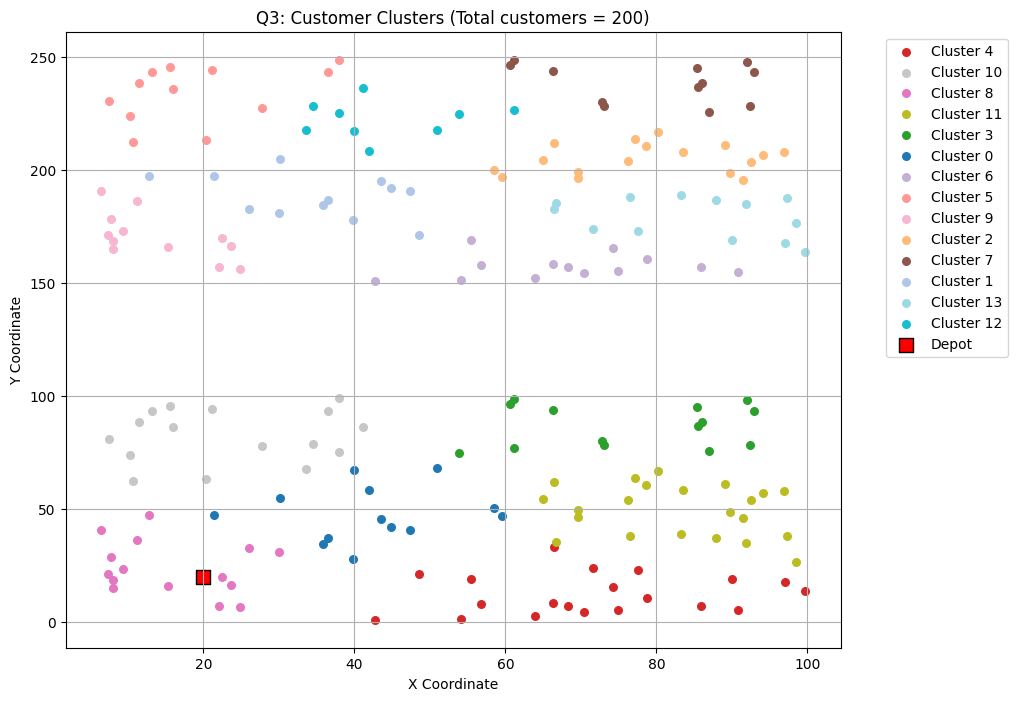

In [ ]:
# Set colors — one color per cluster
colors = plt.cm.tab20(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(10, 8))

# Plot customers in each cluster
for cluster_id, cust_list in cluster_to_customers.items():
    x = [coords[c][0] for c in cust_list]
    y = [coords[c][1] for c in cust_list]
    plt.scatter(x, y, color=colors[cluster_id], label=f'Cluster {cluster_id}', s=30)

# Plot the main depot
plt.scatter(coords[depot_no][0], coords[depot_no][1], c='red', marker='s', s=100, edgecolors='black', label='Depot')

plt.title(f"Q3: Customer Clusters (Total customers = {len(idx_to_cust)})")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend placed on the right
plt.show()


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin_Q3' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual_Q3' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


[Q3] Gen 1: min=6982.90, avg=7578.98
[Q3] Gen 100: min=6031.85, avg=6217.42
[Q3] Gen 200: min=5822.36, avg=6011.50
[Q3] Gen 300: min=5720.71, avg=5978.67
[Q3] Gen 400: min=5568.02, avg=5776.59
[Q3] Gen 500: min=5551.79, avg=5774.71
[Q3] Gen 600: min=5514.45, avg=5714.45
[Q3] Gen 700: min=5467.01, avg=5755.12
[Q3] Gen 800: min=5429.58, avg=5662.55
[Q3] Gen 900: min=5429.58, avg=5692.25
[Q3] Gen 1000: min=5379.57, avg=5618.99
[Q3] Gen 1100: min=5288.90, avg=5588.41
[Q3] Gen 1200: min=5257.85, avg=5544.34
[Q3] Gen 1300: min=5244.74, avg=5542.25
[Q3] Gen 1400: min=5230.88, avg=5496.92
[Q3] Gen 1500: min=5228.64, avg=5445.66
[Q3] Gen 1600: min=5226.80, avg=5444.52
[Q3] Gen 1700: min=5168.34, avg=5375.98
[Q3] Gen 1800: min=5155.03, avg=5443.09
[Q3] Gen 1900: min=5112.48, avg=5321.40
[Q3] Gen 2000: min=5030.16, avg=5278.41
[Q3] Gen 2100: min=5019.88, avg=5316.34
[Q3] Gen 2200: min=4996.53, avg=5264.25
[Q3] Gen 2300: min=4982.18, avg=5206.73
[Q3] Gen 2400: min=4977.05, avg=5238.27
[Q3] Gen 250

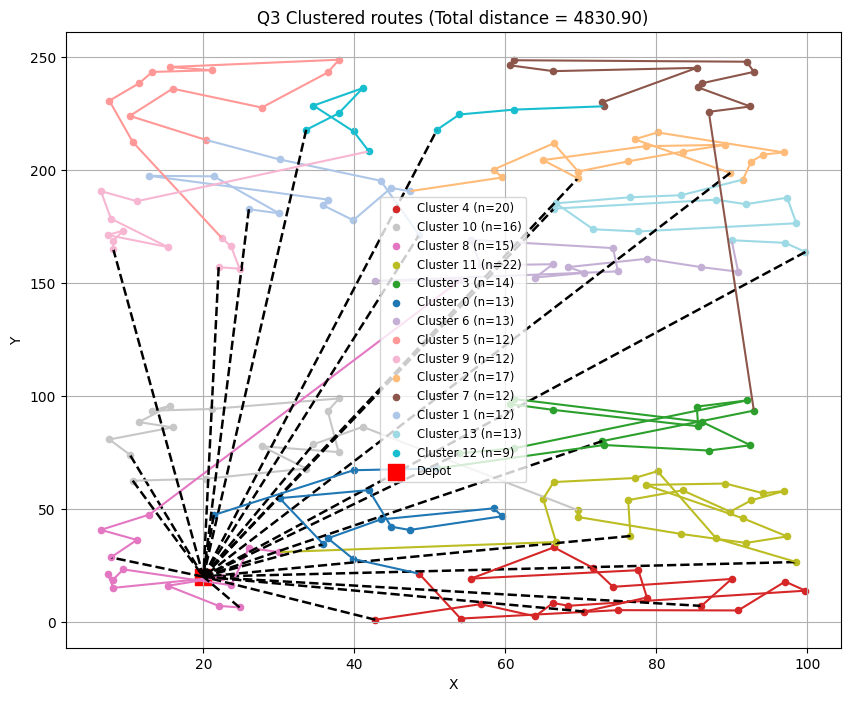

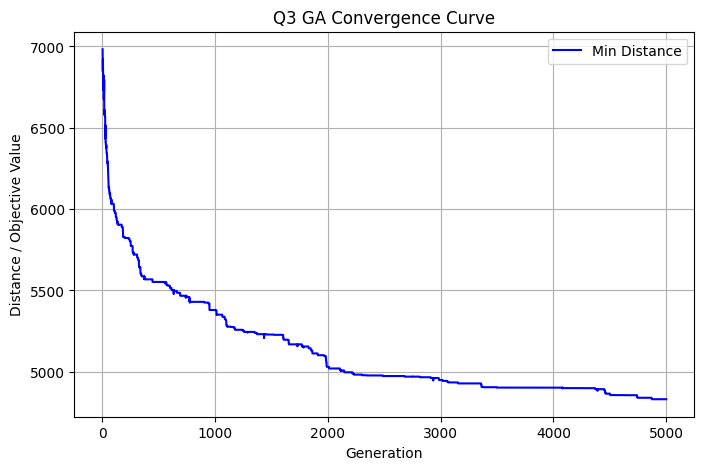

[Q3] Saved q3_best_solution.pkl


In [ ]:
# 4) Construct GA individuals: each individual is represented by a full sequence of customer indices,
#     but before evaluation, repair() ensures "cluster-block continuity"
#     The initial individual generation function randomly shuffles cluster order and shuffles customers within each cluster, then concatenates them
from deap import base, creator, tools, algorithms
creator.create("FitnessMin_Q3", base.Fitness, weights=(-1.0,))
creator.create("Individual_Q3", list, fitness=creator.FitnessMin_Q3)
toolbox_q3 = base.Toolbox()

cluster_ids = sorted(cluster_to_customers.keys())

def gen_grouped_individual():
    # Random cluster order
    region_order = cluster_ids.copy()
    random.shuffle(region_order)
    seq = []
    for cid in region_order:
        custs = cluster_to_customers[cid].copy()
        random.shuffle(custs)
        seq.extend(custs)
    # seq is a sequence of customer NOs, convert to indices (0..n-1) to match idx_to_cust for evaluation
    idx_map = {cust:i for i,cust in enumerate(idx_to_cust)}
    seq_idx = [idx_map[c] for c in seq]
    return creator.Individual_Q3(seq_idx)

toolbox_q3.register("individual", gen_grouped_individual)
toolbox_q3.register("population", tools.initRepeat, list, toolbox_q3.individual)

# repair: adjust any sequence to "cluster-block continuity" — cluster order determined by first occurrence, internal order preserved
def repair_region_blocks(individual):
    # individual: list of indices into idx_to_cust
    # produce customer NO sequence
    seq_nos = [idx_to_cust[i] for i in individual]
    seen = set()
    new_seq = []
    for node in seq_nos:
        c = cust_to_cluster[node]
        if c not in seen:
            seen.add(c)
            # append all nodes of this cluster in the order they appear in seq_nos
            cluster_nodes_in_order = [n for n in seq_nos if cust_to_cluster[n]==c]
            new_seq.extend(cluster_nodes_in_order)
    # convert back to indices
    idx_map = {cust:i for i,cust in enumerate(idx_to_cust)}
    repaired = [idx_map[n] for n in new_seq]
    # replace content
    individual[:] = repaired
    return individual

# define evaluation function, based on existing eval_vrp_classical (expects individual as indices into idx_to_cust)
def evaluate_q3(individual):
    # repair first
    repair_region_blocks(individual)
    cost, segments = eval_vrp_classical(individual)
    return cost

# register GA operators (use cxOrdered & mutShuffleIndexes, repair offspring after operations)
toolbox_q3.register("mate", tools.cxOrdered)
toolbox_q3.register("mutate", tools.mutShuffleIndexes, indpb=0.02)
toolbox_q3.register("select", tools.selTournament, tournsize=3)
toolbox_q3.register("evaluate", evaluate_q3)

# wrap crossover/mutation to apply repair on offspring
def cx_repair(a, b):
    tools.cxOrdered(a, b)
    repair_region_blocks(a)
    repair_region_blocks(b)
    return a, b

def mut_repair(ind):
    tools.mutShuffleIndexes(ind, indpb=0.02)
    repair_region_blocks(ind)
    return (ind,)

toolbox_q3.register("mate_repair", cx_repair)
toolbox_q3.register("mutate_repair", mut_repair)

# 5) Run GA (parameters adjustable)
POP_SIZE = 120
NGEN = 5000
CXPB = 0.75
MUTPB = 0.25

pop = toolbox_q3.population(n=POP_SIZE)
hof_q3 = tools.HallOfFame(3)  # store several best solutions
stats_q3 = tools.Statistics(lambda ind: ind.fitness.values)
stats_q3.register("avg", np.mean)
stats_q3.register("min", np.min)
stats_q3.register("max", np.max)

# custom evolve loop to apply repaired operators
for ind in pop:
    # ensure initial population obeys block structure
    repair_region_blocks(ind)
    ind.fitness.values = toolbox_q3.evaluate(ind)

gen_list, min_list, avg_list, max_list = [], [], [], []

for gen in range(1, NGEN+1):
    offspring = toolbox_q3.select(pop, len(pop))
    offspring = list(map(toolbox_q3.clone, offspring))
    # apply crossover on pairs
    for i in range(1, len(offspring), 2):
        if random.random() < CXPB:
            a, b = offspring[i-1], offspring[i]
            cx_repair(a, b)
            # invalidate fitness
            a.fitness.values = (float('inf'),)
            b.fitness.values = (float('inf'),)
    # mutation
    for i in range(len(offspring)):
        if random.random() < MUTPB:
            mut_repair(offspring[i])
            offspring[i].fitness.values = (float('inf'),)

    # evaluate invalid fitness
    invalid = [ind for ind in offspring if not hasattr(ind, "fitness") or ind.fitness.values[0] == float('inf')]
    for ind in invalid:
        ind.fitness.values = toolbox_q3.evaluate(ind)

    # replace population
    pop[:] = offspring
    # update hof and stats
    hof_q3.update(pop)
    record = stats_q3.compile(pop)

    gen_list.append(gen)
    min_list.append(record['min'])
    avg_list.append(record['avg'])
    max_list.append(record['max'])

    if gen % 100 == 0 or gen==1 or gen==NGEN:
        print(f"[Q3] Gen {gen}: min={record['min']:.2f}, avg={record['avg']:.2f}")

print("[Q3] GA finished. Best objective (distance):", hof_q3[0].fitness.values[0])

# 6) Visualization: plot cluster layout and best route (using hof_q3[0])
best_ind = hof_q3[0]
repair_region_blocks(best_ind)
best_cost, best_segments = eval_vrp_classical(best_ind)
print(f"[Q3] Best total distance (classical eval): {best_cost[0]:.2f}")

# Prepare colors for clusters
colors = plt.cm.tab20(np.linspace(0,1,num_clusters))

plt.figure(figsize=(10,8))
# plot customers by cluster
for cid, custs in cluster_to_customers.items():
    xs = [coords[c][0] for c in custs]
    ys = [coords[c][1] for c in custs]
    plt.scatter(xs, ys, s=20, label=f"Cluster {cid} (n={len(custs)})", color=colors[cid % len(colors)])

# plot depot
depot_coord = coords[depot_no]
plt.scatter([depot_coord[0]], [depot_coord[1]], c='red', s=120, marker='s', label='Depot')

# plot route segments with cluster color, dashed for depot transitions
for i, seg in enumerate(best_segments):
    for j in range(len(seg)-1):
        a, b = seg[j], seg[j+1]
        x1, y1 = coords[a]
        x2, y2 = coords[b]
        # if either a or b is depot, draw as dashed
        if a == depot_no or b == depot_no:
            plt.plot([x1,x2],[y1,y2], linestyle='--', linewidth=1.8, color='k')
        else:
            cidx = cust_to_cluster[a]
            plt.plot([x1,x2],[y1,y2], linestyle='-', linewidth=1.5, color=colors[cidx % len(colors)])

plt.title(f"Q3 Clustered routes (Total distance = {best_cost[0]:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(scatterpoints=1, fontsize='small', loc='best')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(gen_list, min_list, label="Min Distance", color='blue')
plt.xlabel("Generation")
plt.ylabel("Distance / Objective Value")
plt.title("Q3 GA Convergence Curve")
plt.legend()
plt.grid(True)
plt.show()

# 7) Save best solution (including cluster information)
import pickle
out = {
    "best_individual_idx_seq": list(best_ind),
    "best_segments": best_segments,
    "best_distance": best_cost[0],
    "cust_to_cluster": dict(cust_to_cluster),
    "cluster_to_customers": dict(cluster_to_customers)
}
with open("q3_best_solution.pkl", "wb") as f:
    pickle.dump(out, f)
print("[Q3] Saved q3_best_solution.pkl")


# ------------------------------------------------------------------------**

# Q4 MULTI-OBJECTIVE OPTIMIZATION PROBLEM

In [ ]:
"""
Bi-objective VRP:
 - f1: total travel distance (minimize)
 - f2: sum_i (EFFICIENCY_i - d_i) (maximize), where d_i = cumulative distance from depot to customer i along its trip
Two solvers:
 - weighted-sum GA: f = w*f1 - (1-w)*f2  (minimize)
 - NSGA-II (Pareto) with objectives (f1, f2)
Requires: numpy, pandas, matplotlib, deap
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random
import pickle
import os

depot_row = df[df["TYPE"].str.upper().str.contains("DEPOT")].iloc[0]
depot_no = int(depot_row["NO"])
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy()

coords = {int(row["NO"]):(float(row["XCOORD"]), float(row["YCOORD"])) for _,row in df.iterrows()}
demands = {int(row["NO"]):float(row["DEMAND"]) for _,row in df.iterrows()}
EFFICIENCY = {int(row["NO"]): float(row["EFFICIENCY"]) if "EFFICIENCY" in df.columns else 0.0 for _,row in df.iterrows()}
CAPACITY = 200

idx_to_cust = list(customers["NO"])  # Map indices (0..n-1) to actual customer numbers


# Build distance matrix (reused in both solvers)
def build_distance_matrix(coords):
    nodes = sorted(coords.keys())
    n = len(nodes)
    arr = np.array([coords[k] for k in nodes], dtype=float)
    diff = arr[:, None, :] - arr[None, :, :]
    dist = np.sqrt((diff ** 2).sum(axis=2))
    node_to_index = {node: i for i, node in enumerate(nodes)}
    return dist, node_to_index

dist_matrix, node_to_index = build_distance_matrix(coords)


# Evaluator: returns f1 (total distance), f2 (sum of efficiency - d_i), and route segments
def eval_vrp_bi(individual):
    """
    Traverse the permutation 'individual' (list of customer indices).
    Build route segments split when capacity would be exceeded (start a new trip from the depot).
    Compute:
      f1 = total travel distance (including depot returns)
      f2 = sum_i (EFFICIENCY_i - d_i), where d_i is cumulative distance from depot to each customer
    Returns (f1, f2, segments)
    """
    total_dist = 0.0
    total_eff_pen = 0.0  # f2: sum(EFFICIENCY_i - d_i)
    load = 0.0
    cur = depot_no
    segments = []
    seg = [depot_no]
    cum_dist = 0.0  # Cumulative distance within the current segment

    for idx in individual:
        cust = idx_to_cust[idx]
        cust = int(cust)
        demand = demands.get(cust, 0.0)

        # If adding this customer exceeds capacity -> return to depot and start a new trip
        if load + demand > CAPACITY:
            total_dist += dist_matrix[node_to_index[cur], node_to_index[depot_no]]
            seg.append(depot_no)
            segments.append(seg)
            seg = [depot_no]
            cur = depot_no
            load = 0.0
            cum_dist = 0.0

        # Travel from current node to customer
        dist = dist_matrix[node_to_index[cur], node_to_index[cust]]
        total_dist += dist
        cum_dist += dist
        effi = EFFICIENCY.get(cust, 0.0)
        total_eff_pen += (effi - cum_dist)

        seg.append(cust)
        cur = cust
        load += demand

    # Return to depot after the last segment
    total_dist += dist_matrix[node_to_index[cur], node_to_index[depot_no]]
    seg.append(depot_no)
    segments.append(seg)

    f1 = total_dist
    f2 = total_eff_pen
    return f1, f2, segments


# Weighted single-objective GA solver
def run_weighted_ga(w=0.5, pop_size=100, ngen=400, cxpb=0.7, mutpb=0.25, save_best=True):
    """
    Weighted GA: f = w*f1 - (1-w)*f2  (minimize)
    Prints statistics every 100 generations.
    Returns the best individual, its f1, f2, and route segments.
    """
    try:
        creator.create("FitnessWeighted", base.Fitness, weights=(-1.0,))
    except Exception:
        pass
    try:
        creator.create("IndividualW", list, fitness=creator.FitnessWeighted)
    except Exception:
        pass

    toolbox_w = base.Toolbox()
    toolbox_w.register("indices", random.sample, range(len(idx_to_cust)), len(idx_to_cust))
    toolbox_w.register("individual", tools.initIterate, creator.IndividualW, toolbox_w.indices)
    toolbox_w.register("population", tools.initRepeat, list, toolbox_w.individual)

    def eval_weighted(ind):
        f1, f2, _ = eval_vrp_bi(ind)
        val = w * f1 - (1.0 - w) * f2
        return (val,)

    toolbox_w.register("evaluate", eval_weighted)
    toolbox_w.register("mate", tools.cxOrdered)
    toolbox_w.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox_w.register("select", tools.selTournament, tournsize=3)

    pop = toolbox_w.population(n=pop_size)
    hof = tools.HallOfFame(1)

    gen_list, min_list, avg_list = [], [], []

    for gen in range(1, ngen + 1):
        offspring = toolbox_w.select(pop, len(pop))
        offspring = [toolbox_w.clone(ind) for ind in offspring]

        # Apply crossover
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= cxpb:
                toolbox_w.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        # Apply mutation
        for mutant in offspring:
            if random.random() <= mutpb:
                toolbox_w.mutate(mutant)
                del mutant.fitness.values

        # Evaluate invalid individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid_ind:
            ind.fitness.values = toolbox_w.evaluate(ind)

        pop[:] = offspring
        hof.update(pop)

        fits = [ind.fitness.values[0] for ind in pop]
        gen_list.append(gen)
        min_list.append(np.min(fits))
        avg_list.append(np.mean(fits))

        # Print every 100 generations
        if gen % 100 == 0 or gen == 1 or gen == ngen:
            best = hof[0]
            f1, f2, _ = eval_vrp_bi(best)
            print(f"Gen {gen}: Best f1={f1:.2f}, f2={f2:.2f}")

    # Plot convergence
    plt.figure(figsize=(8, 5))
    plt.plot(gen_list, min_list, label="Min Fitness")
    plt.plot(gen_list, avg_list, label="Avg Fitness", linestyle='--')
    plt.xlabel("Generation")
    plt.ylabel("Weighted Objective Value")
    plt.title(f"Convergence Curve (w={w})")
    plt.legend()
    plt.grid(True)
    plt.show()

    best = hof[0]
    f1, f2, segments = eval_vrp_bi(best)

    if save_best:
        saved = {"individual": list(best), "f1": float(f1), "f2": float(f2), "w": float(w)}
        try:
            prev = []
            if os.path.exists("best_solutions_Q4_1.pkl"):
                with open("best_solutions.pkl_Q4_1", "rb") as f:
                    prev = pickle.load(f)
            prev.insert(0, saved)
            prev = prev[:100]
            with open("best_solutions.pkl", "wb") as f:
                pickle.dump(prev, f)
        except Exception as e:
            print("Warning: could not save best_solutions:", e)

    return best, f1, f2, segments


def run_nsga2(pop_size=200, ngen=800, cxpb=0.7, mutpb=0.25, mu=None, lam=None, plot_convergence=True):
    """
    Correct NSGA-II implementation using DEAP with convergence visualization.
    """
    import matplotlib.pyplot as plt

    try:
        if "FitnessMulti" in creator.__dict__:
            del creator.FitnessMulti
        if "IndividualM" in creator.__dict__:
            del creator.IndividualM
    except Exception:
        pass

    creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0))
    creator.create("IndividualM", list, fitness=creator.FitnessMulti)

    toolbox_m = base.Toolbox()
    toolbox_m.register("indices", random.sample, range(len(idx_to_cust)), len(idx_to_cust))
    toolbox_m.register("individual", tools.initIterate, creator.IndividualM, toolbox_m.indices)
    toolbox_m.register("population", tools.initRepeat, list, toolbox_m.individual)

    # Normalized evaluation（Set by many times try TnT）
    f1_max = 2500
    f2_min, f2_max = -4500, -3000

    def eval_multi(ind):
        f1, f2, _ = eval_vrp_bi(ind)
        f1_scaled = f1 / f1_max
        f2_scaled = (f2 - f2_min) / (f2_max - f2_min)
        return (f1_scaled, f2_scaled)

    toolbox_m.register("evaluate", eval_multi)
    toolbox_m.register("mate", tools.cxOrdered)
    toolbox_m.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

    pop = toolbox_m.population(n=pop_size)

    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    for ind in invalid_ind:
        ind.fitness.values = toolbox_m.evaluate(ind)

    pop = tools.selNSGA2(pop, len(pop))

    if mu is None:
        mu = pop_size
    if lam is None:
        lam = pop_size

    gen_list, pareto_size_list, avg_f1_list, avg_f2_list = [], [], [], []

    for gen in range(1, ngen + 1):
        mating_pool = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox_m.clone(ind) for ind in mating_pool]

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= cxpb:
                toolbox_m.mate(ind1, ind2)
                del ind1.fitness.values, ind2.fitness.values
        for mutant in offspring:
            if random.random() <= mutpb:
                toolbox_m.mutate(mutant)
                del mutant.fitness.values

        invalid_off = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid_off:
            ind.fitness.values = toolbox_m.evaluate(ind)

        pop = tools.selNSGA2(pop + offspring, pop_size)

        f1_vals = [ind.fitness.values[0] for ind in pop]
        f2_vals = [ind.fitness.values[1] for ind in pop]
        pareto = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]

        gen_list.append(gen)
        pareto_size_list.append(len(pareto))
        avg_f1_list.append(np.mean(f1_vals))
        avg_f2_list.append(np.mean(f2_vals))

        if gen % 500 == 0 or gen == 1 or gen == ngen:
            pareto_sample = [(round(float(ind.fitness.values[0]), 2),
                              round(float(ind.fitness.values[1]), 2)) for ind in pareto[:5]]
            print(f"Gen {gen}: Pareto front size = {len(pareto)} | sample objs: {pareto_sample}")

    # Plot convergence
    if plot_convergence:
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(gen_list, avg_f1_list, label="Avg f1 (Distance)", color="blue")
        plt.plot(gen_list, avg_f2_list, label="Avg f2 (Efficiency)", color="orange")
        plt.xlabel("Generation")
        plt.ylabel("Normalized Objective Value")
        plt.title("NSGA-II Objective Averages")
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(gen_list, pareto_size_list, color="green")
        plt.xlabel("Generation")
        plt.ylabel("Pareto Front Size")
        plt.title("NSGA-II Pareto Front Growth")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    pareto = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    return pop, pareto


# Visualization functions
def plot_route(segments, title=None):
    plt.figure(figsize=(9, 7))
    plt.scatter(customers["XCOORD"], customers["YCOORD"], c='blue', s=40, label="Customer")
    plt.scatter(depot_row["XCOORD"], depot_row["YCOORD"], c='red', marker='s', s=100,
                edgecolors='black', label="Depot")

    colors = plt.cm.tab20(np.linspace(0, 1, len(segments)))
    for i, seg in enumerate(segments):
        for j in range(len(seg) - 1):
            x1, y1 = coords[seg[j]]
            x2, y2 = coords[seg[j + 1]]
            if seg[j] == depot_no or seg[j + 1] == depot_no:
                plt.plot([x1, x2], [y1, y2], color=colors[i], lw=2, linestyle='--')
            else:
                plt.plot([x1, x2], [y1, y2], color=colors[i], lw=2, linestyle='-')
        if len(seg) > 2:
            plt.text(coords[seg[1]][0], coords[seg[1]][1], f"Trip {i + 1}", color=colors[i])

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, linestyle='-', label='Customer → Customer'),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label='Depot ↔ Customer')
    ]
    plt.legend(handles=legend_elements)
    if title:
        plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


def plot_pareto(pareto):
    f1s = [ind.fitness.values[0] for ind in pareto]
    f2s = [ind.fitness.values[1] for ind in pareto]
    plt.figure(figsize=(7, 5))
    plt.scatter(f1s, f2s, s=30)
    plt.xlabel("Total distance (f1) -- minimize")
    plt.ylabel("Total efficiency score (f2) -- maximize")
    plt.title("Pareto front (approx.)")
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    random.seed(42)
    # Weighted GA with several w values
    for w in [0.25, 0.5, 0.75, 1.0]:
        print(f"\n=== Running weighted GA with w={w} ===")
        best, f1, f2, segments = run_weighted_ga(w=w, pop_size=120, ngen=4000, cxpb=0.75, mutpb=0.25, save_best=False)
        print(f"w={w} -> f1={f1:.2f}, f2={f2:.2f}")
        plot_route(segments, title=f"Weighted GA (w={w}) f1={f1:.2f}, f2={f2:.2f}")

    # NSGA-II solver
    print("\n=== Running NSGA-II ===")
    pop, pareto = run_nsga2(pop_size=120, ngen=4000, cxpb=0.75, mutpb=0.25)
    print(f"Final Pareto size: {len(pareto)}")
    for i, ind in enumerate(pareto[:8]):
        f1, f2 = ind.fitness.values
        print(f"Pareto {i + 1}: f1={f1:.2f}, f2={f2:.2f}")

    pareto_sorted_by_f1 = sorted(pareto, key=lambda ind: ind.fitness.values[0])
    sample = pareto_sorted_by_f1[0]
    f1samp, f2samp, segsamp = eval_vrp_bi(sample)
    plot_route(segsamp, title=f"Sample Pareto route (f1={f1samp:.2f}, f2={f2samp:.2f})")


# Q5😭

In [ ]:
"""
Pickup-and-Delivery VRP with GA (DEAP)
- Randomly assign 30% of customers as pickup (negative demand)
- Vehicle load must stay within [0, CAPACITY]
- Depot can serve as reload/unload point (set load to CAP or 0 based on next customer type)
- Evaluation function applies large penalty for constraint violations
"""

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pickle
from deap import base, creator, tools, algorithms

RND_SEED = 42
random.seed(RND_SEED)
np.random.seed(RND_SEED)

# Separate depot and customers
depots = df[df["TYPE"].str.upper().str.contains("DEPOT")]
main_depot_row = depots.iloc[depots["NO"].idxmin()]
main_depot_no = int(main_depot_row["NO"])
other_depots = depots[depots["NO"] != main_depot_no]
other_depot_nos = list(other_depots["NO"])

customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy()
idx_to_cust = list(customers["NO"])
print("Main depot:", main_depot_no, "Other depots:", other_depot_nos, "Customers:", len(idx_to_cust))

# Randomly mark 30% of customers as pickup
demands = {int(row["NO"]): float(row["DEMAND"]) for _, row in df.iterrows()}
cust_ids = list(customers["NO"])
n_pickups = int(round(0.30 * len(cust_ids)))
pickup_sample = set(random.sample(cust_ids, n_pickups))
print(f"{n_pickups} customers set as pickup (negative demand)")

print(customers["DEMAND"].describe())
print("Negative demand customers =", (customers["DEMAND"] < 0).sum())

# Create signed demands: positive = delivery, negative = pickup
signed_demands = demands.copy()
for c in cust_ids:
    if c in pickup_sample:
        signed_demands[c] = -abs(demands[c])
    else:
        signed_demands[c] = abs(demands[c])

# Ensure depot demand = 0
for d in depots["NO"]:
    signed_demands[int(d)] = 0.0

# Distance matrix
coords = {int(row["NO"]):(float(row["XCOORD"]), float(row["YCOORD"])) for _,row in df.iterrows()}
CAPACITY = 200.0

def build_distance_matrix(coords):
    nodes = sorted(coords.keys())
    arr = np.array([coords[k] for k in nodes])
    diff = arr[:,None,:] - arr[None,:,:]
    dist = np.sqrt((diff**2).sum(axis=2))
    node_to_index = {node:i for i,node in enumerate(nodes)}
    return dist, node_to_index

dist_matrix, node_to_index = build_distance_matrix(coords)

# Evaluation function for pickup-and-delivery
BIG_PENALTY = 1e6

def eval_vrp_pickup_delivery(individual):
    total_dist = 0.0
    load = CAPACITY  # start with full load
    cur = main_depot_no
    segments = []
    seg = [main_depot_no]
    violations = 0
    load_history = [("start", main_depot_no, load)]

    # helper: find nearest depot
    def nearest_depot_from(node):
        candidates = other_depot_nos + [main_depot_no]
        return min(candidates, key=lambda d: dist_matrix[node_to_index[node], node_to_index[d]])

    for idx in individual:
        cust = idx_to_cust[idx]
        demand = signed_demands[cust]  # positive = delivery, negative = pickup

        # Check if single demand exceeds capacity
        if abs(demand) > CAPACITY + 1e-9:
            violations += 1
            total_dist += BIG_PENALTY
            total_dist += dist_matrix[node_to_index[cur], node_to_index[cust]]
            seg.append(cust)
            cur = cust
            load_history.append(("visit_unfeasible", cust, load))
            continue

        # Compute new load (delivery reduces load, pickup increases load)
        load_after = load - demand
        # If out of range, go to nearest depot first
        if not (0 - 1e-9 <= load_after <= CAPACITY + 1e-9):
            nd = nearest_depot_from(cur)
            total_dist += dist_matrix[node_to_index[cur], node_to_index[nd]]
            seg.append(nd)
            cur = nd
            # Adjust load at depot based on next customer type
            if demand > 0:
                load = CAPACITY
            else:
                load = CAPACITY - demand - 10
            load_history.append(("depot_adjust", nd, load))
            # Recalculate load_after
            load_after = load - demand
            if not (0 - 1e-9 <= load_after <= CAPACITY + 1e-9):
                violations += 1
                total_dist += BIG_PENALTY

        # Move to customer
        total_dist += dist_matrix[node_to_index[cur], node_to_index[cust]]
        seg.append(cust)
        cur = cust
        load = load_after
        load_history.append(("visit", cust, load))

    # Return to main depot
    total_dist += dist_matrix[node_to_index[cur], node_to_index[main_depot_no]]
    seg.append(main_depot_no)
    segments.append(seg)
    load_history.append(("end_return", main_depot_no, load))

    penalized_distance = total_dist
    return (penalized_distance,), segments, violations, load_history, total_dist

# -----------------------------
# GA setup (DEAP)
# -----------------------------
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(idx_to_cust)), len(idx_to_cust))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation wrapper (only return fitness)
def evaluate_wrapper(ind):
    fit, segs, viol, lh, raw = eval_vrp_pickup_delivery(ind)
    return fit

toolbox.register("evaluate", evaluate_wrapper)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


Main depot: 0 Other depots: [1, 2, 3, 4] Customers: 200
60 customers set as pickup (negative demand)
count    200.000000
mean      11.110000
std        5.629954
min        1.000000
25%        7.000000
50%       11.500000
75%       16.000000
max       20.000000
Name: DEMAND, dtype: float64
Negative demand customers = 0


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



✅ 最佳带惩罚的目标值 (距离+罚): 1691.77
   原始实际距离（不含惩罚）: 1691.77
   约束违反次数: 0
Trip 1: 0 -> 70 -> 46 -> 40 -> 97 -> 100 -> 53 -> 58 -> 104 -> 13 -> 16 -> 101 -> 43 -> 94 -> 92 -> 7 -> 54 -> 49 -> 93 -> 35 -> 62 -> 5 -> 45 -> 12 -> 63 -> 80 -> 82 -> 57 -> 32 -> 56 -> 17 -> 64 -> 39 -> 73 -> 103 -> 99 -> 59 -> 81 -> 102 -> 11 -> 15 -> 41 -> 96 -> 95 -> 65 -> 76 -> 30 -> 78 -> 79 -> 6 -> 19 -> 91 -> 33 -> 21 -> 88 -> 50 -> 69 -> 74 -> 72 -> 22 -> 60 -> 36 -> 68 -> 52 -> 44 -> 34 -> 0 -> 23 -> 27 -> 10 -> 37 -> 25 -> 90 -> 42 -> 77 -> 29 -> 31 -> 51 -> 84 -> 14 -> 86 -> 89 -> 47 -> 75 -> 98 -> 20 -> 55 -> 18 -> 1 -> 28 -> 87 -> 85 -> 48 -> 24 -> 26 -> 71 -> 9 -> 67 -> 61 -> 8 -> 38 -> 66 -> 83 -> 0


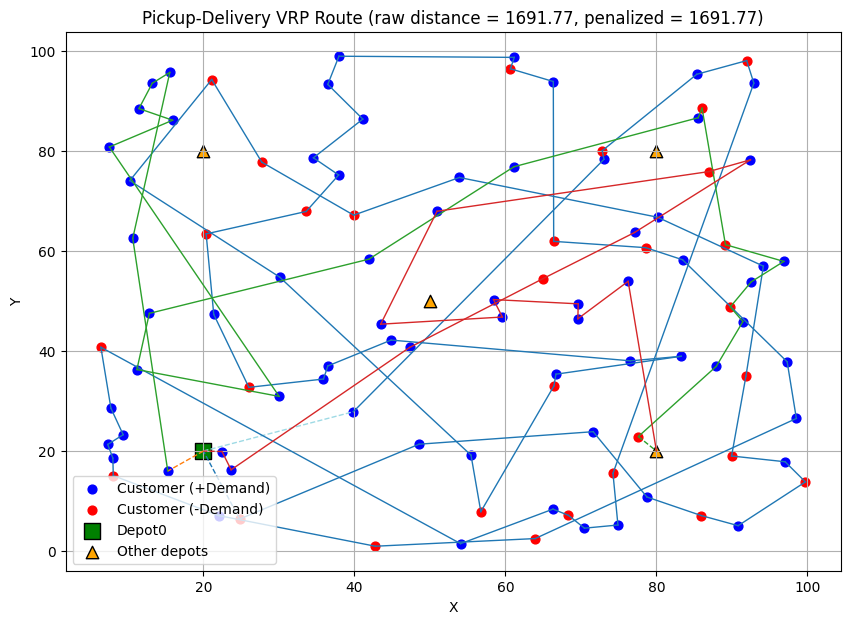

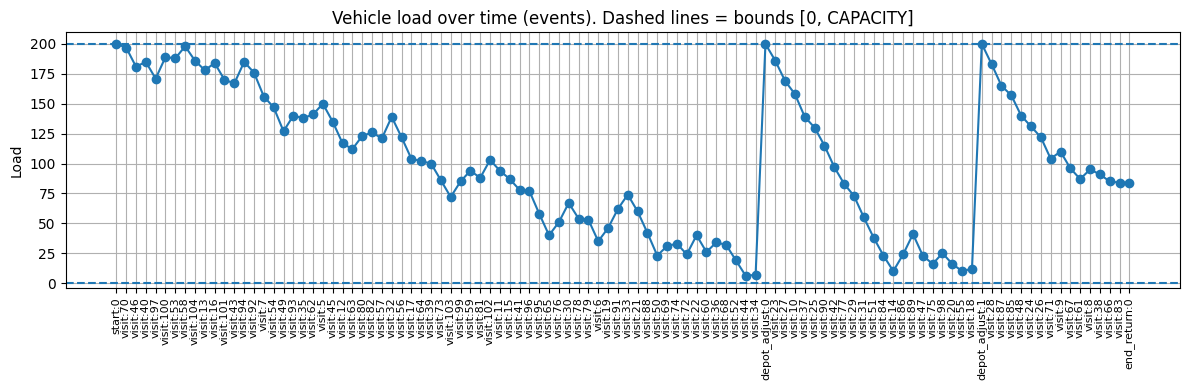

In [ ]:
# 6. Load historical best solutions (if exists)
try:
    with open("Q5_vrp_result.pkl", "rb") as f:
        saved_solutions = pickle.load(f)

    if isinstance(saved_solutions, dict):
        # Single best solution
        print("✅ 读取了一个历史最优解")
        initial_pop = [creator.Individual(saved_solutions["best_individual"])]
    elif isinstance(saved_solutions, list):
        # Multiple best solutions
        print(f"✅ 读取了 {len(saved_solutions)} 个历史最优解")
        initial_pop = [creator.Individual(sol["individual"]) for sol in saved_solutions]
    else:
        raise ValueError("Unknown data structure type")

except Exception as e:
    print("⚠️ 未找到历史最优解文件或读取失败，将随机初始化种群", e)
    initial_pop = []


# 7. Run GA
POP_SIZE = 120
NGEN = 6000
N_INIT_FROM_SAVED = len(initial_pop)
n_random = max(0, POP_SIZE - N_INIT_FROM_SAVED)
pop = initial_pop + [toolbox.individual() for _ in range(n_random)]

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
logbook = tools.Logbook()

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=NGEN,
                                  stats=stats, halloffame=hof, verbose=False)

best = hof[0]
eval_out = eval_vrp_pickup_delivery(best)
best_fit = eval_out[0][0]
best_segments = eval_out[1]
violations = eval_out[2]
load_history = eval_out[3]
raw_distance = eval_out[4]

print(f"\n✅ 最佳带惩罚的目标值 (距离+罚): {best_fit:.2f}")
print(f"   原始实际距离（不含惩罚）: {raw_distance:.2f}")
print(f"   约束违反次数: {violations}")

# Print each trip's route
for i, s in enumerate(best_segments):
    print(f"Trip {i+1}: {' -> '.join(map(str,s))}")


# -----------------------------
# 8. Visualization: routes + vehicle load curve
# -----------------------------
# Route plot
plt.figure(figsize=(10,7))

# Plot customers with positive/negative demand separately
neg_customers = customers[customers["NO"].isin(pickup_sample)]  # pickup customers
pos_customers = customers[~customers["NO"].isin(pickup_sample)]  # other customers

plt.scatter(pos_customers["XCOORD"], pos_customers["YCOORD"],
            c='blue', s=40, label="Customer (+Demand)")
plt.scatter(neg_customers["XCOORD"], neg_customers["YCOORD"],
            c='red', s=40, label="Customer (-Demand)")

# Plot depots
plt.scatter(main_depot_row["XCOORD"], main_depot_row["YCOORD"],
            c='green', marker='s', s=120, edgecolors='black', label="Depot0")
plt.scatter(other_depots["XCOORD"], other_depots["YCOORD"],
            c='orange', marker='^', s=80, edgecolors='black', label="Other depots")

# Plot routes
colors = plt.cm.tab20(np.linspace(0,1,len(best_segments)+10))

for i, seg in enumerate(best_segments):
    c = -1
    for j in range(len(seg)-1):
        x1, y1 = coords[seg[j]]
        x2, y2 = coords[seg[j+1]]
        # Depot-related connections are dashed
        if seg[j] == main_depot_no or seg[j+1] == main_depot_no or seg[j+1] in other_depot_nos:
            plt.plot([x1,x2],[y1,y2], color=colors[c], lw=1, linestyle='--')
            c = c+1
        else:
            plt.plot([x1,x2],[y1,y2], color=colors[c], lw=1)

plt.title(f"Pickup-Delivery VRP Route (raw distance = {raw_distance:.2f}, penalized = {best_fit:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()


# Vehicle load over visit sequence
# Extract sequence from load_history (recorded as events: ('start'/'depot_adjust'/'visit', node, load))
events = load_history
xlabels = []
loads = []
for ev in events:
    typ, node, l = ev
    xlabels.append(f"{typ}:{int(node)}")
    loads.append(l)

plt.figure(figsize=(12,4))
plt.plot(loads, marker='o')
plt.axhline(0, linestyle='--')
plt.axhline(CAPACITY, linestyle='--')
plt.xticks(ticks=range(len(xlabels)), labels=xlabels, rotation=90, fontsize=8)
plt.ylabel("Load")
plt.title("Vehicle load over time (events). Dashed lines = bounds [0, CAPACITY]")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
result_out = {
    "best_individual": list(best),
    "best_segments": best_segments,
    "penalized_distance": best_fit,
    "raw_distance": raw_distance,
    "violations": violations,
    "load_history": load_history,
    "signed_demands_sampled_pickups": list(pickup_sample),
}
with open("Q5_vrp_result.pkl", "wb") as f:
    pickle.dump(result_out, f)
print("结果已保存到 Q5_vrp_result.pkl")

结果已保存到 pd_vrp_result.pkl
